

```
Student Name: Meer Aram Omer
Student ID: 22451299
Unit Name: Big Data
year: 2023-2024
```



**<H2>`Analyzing Cycle Hire Usage Patterns in London`<h2>**



<img src='https://t4.ftcdn.net/jpg/02/68/60/81/360_F_268608148_3j2zpeHzBrByT09sKl16MM9W4HIVm1ef.jpg' width='900' height='250'>

**Santander Cycles scheme** is London's self-service bike-sharing scheme which is one of the greatest services in London and people utilize it for short journies. The main aim of this spectacular service is to provide convenient and enviromentally friendly transportaion <b><a href='https://www.santander.co.uk/personal/support/understanding-our-services/santander-cycles#:~:text=Santander%20Cycles%20is%20Londons%20self,sharing%20scheme%20for%20short%20journeys.'>[Source]</a></b>. The main objective of this project is to perform some analysis and research hypothesis on `cycle hire usage` dataset, and investigate wether rides in 2014 starting from Baylis Road, Waterloo station were shorter compared to other stations. n this project, **PySpark** will be used to analyze the `cycle hire usage` dataset. The process has been divided into several steps as stated below:

* ✅ **Part 1:** <i>Creating SparkSession object and Feature Exploration</i>
* ✅ **Part 2:** <i>Data Cleaning and Preparation</i>
* ✅ **part 3:** <i>Feature Engineering</i>
* ✅ **Part 4:** <i>Exploratory Data Analysis</i>
* ✅ **Part 5:** <i>Hypothesis Test</i>

In [ ]:
# Firstly, PySpark need to be installed.
%%capture
!pip install pyspark

<h4> ✅ Importing relevant libraries </h4>

In [ ]:
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.types import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

%config InlineBackend.figure_format = 'svg'
plt.rcParams ['figure.figsize'] = (10,5)
sns.set(style='white', context='talk', font_scale=0.8)

In [ ]:
# Getting the dataset and unzip it.
%%capture
!wget https://cycling.data.tfl.gov.uk/usage-stats/cyclehireusagestats-2014.zip
!unzip cyclehireusagestats-2014.zip

In [ ]:
# Showing the datasets.
!ls

'10a. Journey Data Extract 14Sep14-27Sep14.csv'  '3. Journey Data Extract 02Mar14-31Mar14.csv'
'10b. Journey Data Extract 28Sep14-11Oct14.csv'  '4. Journey Data Extract 01Apr14-26Apr14.csv'
'11a. Journey Data Extract 12Oct14-08Nov14.csv'  '5. Journey Data Extract 27Apr14-24May14.csv'
'11b. Journey Data Extract 12Oct14-08Nov14.csv'  '6. Journey Data Extract 25May14-21Jun14.csv'
'12a. Journey Data Extract 09Nov14-06Dec14.csv'  '7. Journey Data Extract 22Jun14-19Jul14.csv'
'12b. Journey Data Extract 09Nov14-06Dec14.csv'  '8a Journey Data Extract 20Jul14-31Jul14.csv'
'13a. Journey Data Extract 07Dec14-21Dec14.csv'  '8b Journey Data Extract 01Aug14-16Aug14.csv'
'13b. Journey Data Extract 22Dec14-03Jan15.csv'  '9a Journey Data Extract 17Aug14-31Aug14.csv'
'14. Journey Data Extract 08Dec13-04Jan14.csv'	 '9b Journey Data Extract 01Sep14-13Sep14.csv'
'1. Journey Data Extract 05Jan14-02Feb14.csv'	  cyclehireusagestats-2014.zip
'2. Journey Data Extract 03Feb14-01Mar14.csv'	  sample_data


## ✅ **Part 1:** <i>Creating SparkSession object and Feature Exploration </i>

* SparkSession is an interface which combines Spark's different functionalities into one single entry point.

In [ ]:
spark_session = SparkSession.builder.appName("Transport for London").getOrCreate()

In [ ]:
cycle_hire = (spark_session.read.format('csv')
         .option("header", "true")
         .option("inferSchema", "true")
         .load('./*Journey*.csv'))

In [ ]:
# Exploring the shape of the dataset

rows = '{:,}'.format(cycle_hire.count())
columns = len(cycle_hire.columns)

print(f"this dataset is composed of {rows} rows and {columns} columns")

this dataset is composed of 11,481,596 rows and 9 columns


In [ ]:
cycle_hire.show(2)

+---------+--------+-------+----------------+-------------+--------------------+----------------+---------------+--------------------+
|Rental Id|Duration|Bike Id|        End Date|EndStation Id|     EndStation Name|      Start Date|StartStation Id|   StartStation Name|
+---------+--------+-------+----------------+-------------+--------------------+----------------+---------------+--------------------+
| 34263367|    1080|   9076|24/06/2014 00:57|          695|Islington Green, ...|24/06/2014 00:39|            311|Foley Street, Fit...|
| 34603487|     660|   6328|03/07/2014 11:51|          695|Islington Green, ...|03/07/2014 11:40|             22|Northington Stree...|
+---------+--------+-------+----------------+-------------+--------------------+----------------+---------------+--------------------+
only showing top 2 rows



## ✅ **Part 2:** <i>Data Cleaning and Preparation </i>

Now lets explore the null values and try to find a good approach to fix this issue.

In [ ]:
null_counts = [cycle_hire.where(col(c).isNull()).count() for c in cycle_hire.columns]

In [ ]:
# Combine both dataset columns with the number of null observations for each column
null_counts_dict = dict(zip(cycle_hire.columns, null_counts))

# Using pandas dataframe to illustrate the missing values of each column in our dataset
(pd.DataFrame(null_counts_dict.values()).T.rename(index={0:"Missing Values"})).set_axis(null_counts_dict.keys(), axis=1)

,Rental Id,Duration,Bike Id,End Date,EndStation Id,EndStation Name,Start Date,StartStation Id,StartStation Name
Missing Values,1239113,1239113,1239113,1239113,1239245,1239245,1239113,1239113,1239113


In [ ]:
cycle_hire.filter(cycle_hire.Duration.isNull()).show(10)

+---------+--------+-------+--------+-------------+---------------+----------+---------------+-----------------+
|Rental Id|Duration|Bike Id|End Date|EndStation Id|EndStation Name|Start Date|StartStation Id|StartStation Name|
+---------+--------+-------+--------+-------------+---------------+----------+---------------+-----------------+
|     NULL|    NULL|   NULL|    NULL|         NULL|           NULL|      NULL|           NULL|             NULL|
|     NULL|    NULL|   NULL|    NULL|         NULL|           NULL|      NULL|           NULL|             NULL|
|     NULL|    NULL|   NULL|    NULL|         NULL|           NULL|      NULL|           NULL|             NULL|
|     NULL|    NULL|   NULL|    NULL|         NULL|           NULL|      NULL|           NULL|             NULL|
|     NULL|    NULL|   NULL|    NULL|         NULL|           NULL|      NULL|           NULL|             NULL|
|     NULL|    NULL|   NULL|    NULL|         NULL|           NULL|      NULL|           NULL|  

As we can observe above over one million Null observations for all the columns, the best approach to adopt is to drop all these observations as these rows might not provide useful information.

In [ ]:
cycle_hire = cycle_hire.na.drop()

In [ ]:
# [cycle_hire.where(col(c).isNull()).count() for c in cycle_hire.columns]

We successfully dropped all the Null values  

* Now we investigate wether rides in 2014 starting from Baylis Road, Waterloo station were shorter compared to other stations.
* We subset our data by splitting duration for Baylis Road, Waterloo station and other stations and perform some statistical tests to test whether the duration for Baylis Road, Waterloo station were shorter compared to other stations or not.

## ✅ **Part 3:** <i>Feature Engineering </i>

* In this step we filter the data and create some new columns for analysis purpose

In [ ]:
# First we do some feature engineering and split the Start Date into Date
cycle_hire_with_years = cycle_hire.withColumn("Year", to_date(split(cycle_hire["Start Date"], " ")[0], "dd/MM/yyyy"))

In [ ]:
# We also extract month from 'year' column to create 'season' column later on
cycle_hire_with_years = cycle_hire_with_years.withColumn("Month", month(cycle_hire_with_years['Year']))

In [ ]:
# After that we filter the data to include only 2014
cycle_hire_2014 = cycle_hire_with_years.filter(cycle_hire_with_years["Year"].contains('2014'))

In [ ]:
# Next, we define a custom function for filtering months
def seasons(date):
  if date in range(3,6):
    return "Spring"
  elif date in range(6,9):
    return "Summer"
  elif date in range(9,12):
    return 'Autumn'
  else:
    return 'Winter'

We utilize **UDF** to extend the functionality of Spark and create custom functions to create season column.

In [ ]:
# We register the UDF
get_season_udf = udf(seasons, StringType())

In [ ]:
# Here we pass the Month coulmn the seasons function that we created already, and put the result of the function into Season column
cycle_hire_2014 = cycle_hire_2014.withColumn("Month", cycle_hire_2014["Month"]).withColumn("Seasons", get_season_udf(col("Month")))

In [ ]:
cycle_hire_2014 = cycle_hire_2014.withColumn('Duration(minute)', col('Duration')/60)

After we did some feature engineering, we split our data into two parts:
* Baylis Road, Waterloo
* Other stations

In [ ]:
# Now lets split the data
waterloo_station = cycle_hire_2014.filter(col("StartStation Name") == 'Baylis Road, Waterloo')
other_stations = cycle_hire_2014.filter(col("StartStation Name") != 'Baylis Road, Waterloo')

In [ ]:
waterloo_station.show(2)

+---------+--------+-------+----------------+-------------+--------------------+----------------+---------------+--------------------+----------+-----+-------+----------------+
|Rental Id|Duration|Bike Id|        End Date|EndStation Id|     EndStation Name|      Start Date|StartStation Id|   StartStation Name|      Year|Month|Seasons|Duration(minute)|
+---------+--------+-------+----------------+-------------+--------------------+----------------+---------------+--------------------+----------+-----+-------+----------------+
| 34335942|     600|   7213|25/06/2014 18:59|          199|Great Tower Stree...|25/06/2014 18:49|            272|Baylis Road, Wate...|2014-06-25|    6| Summer|            10.0|
| 34292680|     540|  11506|24/06/2014 18:12|          199|Great Tower Stree...|24/06/2014 18:03|            272|Baylis Road, Wate...|2014-06-24|    6| Summer|             9.0|
+---------+--------+-------+----------------+-------------+--------------------+----------------+---------------+--

In [ ]:
other_stations.show(2)

+---------+--------+-------+----------------+-------------+--------------------+----------------+---------------+--------------------+----------+-----+-------+----------------+
|Rental Id|Duration|Bike Id|        End Date|EndStation Id|     EndStation Name|      Start Date|StartStation Id|   StartStation Name|      Year|Month|Seasons|Duration(minute)|
+---------+--------+-------+----------------+-------------+--------------------+----------------+---------------+--------------------+----------+-----+-------+----------------+
| 34263367|    1080|   9076|24/06/2014 00:57|          695|Islington Green, ...|24/06/2014 00:39|            311|Foley Street, Fit...|2014-06-24|    6| Summer|            18.0|
| 34603487|     660|   6328|03/07/2014 11:51|          695|Islington Green, ...|03/07/2014 11:40|             22|Northington Stree...|2014-07-03|    7| Summer|            11.0|
+---------+--------+-------+----------------+-------------+--------------------+----------------+---------------+--

## ✅ **Part 4:** <i>Exploratory Data Analysis</i>
* Before we do any statistical test and find out whether there is a significant difference between the duration of Baylyis Road, Waterloo and other station, and explore if the duration of the former is shorter compared to the latter, we will be conducting some distribution analysis of the duration for both samples in different season and some other analysis.  

* First, lets do produce descriptive statistics for both samples.

In [ ]:
# First, we calculate discriptive statistics for both samples

Waterloo_station_mean = waterloo_station.select(mean('Duration')).collect()[0][0]
Waterloo_station_std  = waterloo_station.select(stddev('Duration')).collect()[0][0]
Waterloo_station_min  = waterloo_station.selectExpr('min(Duration)').collect()[0][0]
Waterloo_station_max  = waterloo_station.selectExpr('max(Duration)').collect()[0][0]

In [ ]:
other_station_mean = other_stations.select(mean('Duration')).collect()[0][0]
other_station_std  = other_stations.select(stddev('Duration')).collect()[0][0]
other_station_min  = other_stations.selectExpr('min(Duration)').collect()[0][0]
other_station_max  = other_stations.selectExpr('max(Duration)').collect()[0][0]

In [ ]:
# Now we Create DataFrame with descriptive statistics for both samples
statistics_waterloo_station = {
    "Min": Waterloo_station_min,
    "Max":Waterloo_station_max,
    "Mean":Waterloo_station_mean,
    "Standard Deviation":Waterloo_station_std
}

statistics_other_station = {
    "Min": other_station_min,
    "Max":other_station_max,
    "Mean":other_station_mean,
    "Standard Deviation":other_station_std
}

In [ ]:
# Here we combine both stations statistics and show it in a dataframe
waterlo_stats = pd.DataFrame(
    statistics_waterloo_station.values()).set_axis(statistics_waterloo_station.keys()).T.rename(index={0:'Waterloo Station'}
                                                                                                )
other_stats = pd.DataFrame(
    statistics_other_station.values()).set_axis(statistics_other_station.keys()).T.rename(index={0:'other Station'}
                                                                                          )
pd.concat(
[waterlo_stats, other_stats],
           axis=0
         )

,Min,Max,Mean,Standard Deviation
Waterloo Station,0,9960,1044.431642,6403.25112
other Station,-1020,99900,1465.934425,12986.705325


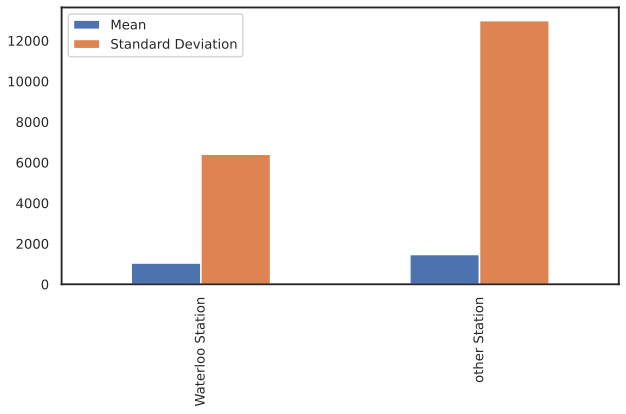

In [ ]:
descriptive_stats = pd.concat(
[waterlo_stats, other_stats],
           axis=0
         )
descriptive_stats.plot(kind='bar');

In [ ]:
# Extracting the duration from both samples in to a list for plotting purposes
waterloo_duration = waterloo_station.select("Duration").rdd.flatMap(lambda x: x).collect()
other_stations_duration = other_stations.select("Duration").rdd.flatMap(lambda x: x).collect()

In [ ]:
# Converting the values into integer
waterloo_duration = [int(values) for values in waterloo_duration]
other_stations_duration = [int(values) for values in other_stations_duration]

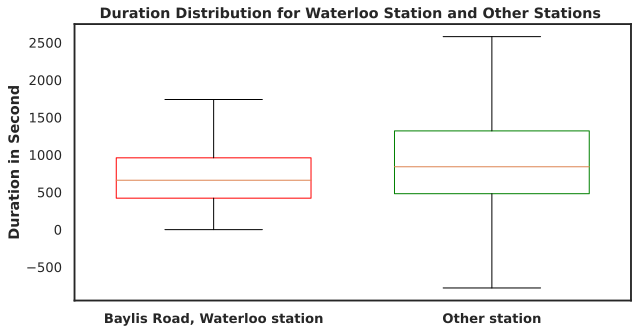

In [ ]:
# Creating a figure and axes object
fig, ax = plt.subplots();

# Plotting Baylis Road, Waterloo station duration
ax.boxplot(waterloo_duration, positions=[1], widths=0.7, showfliers=False, boxprops=dict(color="red"));

# Plotting other station duration
ax.boxplot(other_stations_duration, positions=[2], widths=0.7, showfliers=False, boxprops=dict(color="green"));

# Setting Labels for X axis
ax.set_xticklabels(['Baylis Road, Waterloo station', 'Other station'], fontweight='bold');

# Setting title for the plot
ax.set_title("Duration Distribution for Waterloo Station and Other Stations ", fontweight='bold');

# setting label for Y axis
ax.set_ylabel("Duration in Second", fontweight='bold');

Taking clue from above statistics and plot we can say that:

* Minimum values for both samples are suspecious, zero duration for Waterloo station tell us that some rides might started and returned immediately or canceled, or there might be some data entry error. We will exclude the zero records from our data as it will not impact the analysis.

* There are obviously negative values for other stations, in this case we assume that these values entered incorrectly and we take the absolute value for the duration column to change the negatives to positives.

* The mean value of Baylis Road, Waterloo station is lower than other station which indicated that the rides could take longer from other stations compared to Baylis Road, Waterloo station.

* We can clearly see that we have outliers, we will be dealing with it later on.

* over all the duration is highly spread out from the mean, however, other station's standard deviation is significantly higher than Baylis Road, Waterloo station's standard deviation.


#### ✅ Dealing with outliers
* Looking at the descriptive statistics, it is clear that we have outliers and we have to deal with it so we can get an accurate hypothesis later on.
* we will be using Z-test to detect the outliers and exclude them.

In [ ]:
# Converting duration to double
waterloo_station = waterloo_station.withColumn("Duration", waterloo_station["Duration"].cast("double"))
other_stations = other_stations.withColumn('Duration', other_stations['Duration'].cast('double'))

In [ ]:
# Define a threshold to exclude the outliers
z_threshold = 3

# Exclude outliers using Z-test for waterloo station
waterloo_station = waterloo_station.filter((col("Duration") >= Waterloo_station_mean - z_threshold * Waterloo_station_std) &
                                             (col("Duration") <= Waterloo_station_mean + z_threshold * Waterloo_station_std))

# Exclude outliers using Z-test for other station
other_stations = other_stations.filter((col("Duration") >= other_station_mean - z_threshold * other_station_std) &
                                             (col("Duration") <= other_station_mean + z_threshold * other_station_std))

We successfully managed to exclude the outliers

In [ ]:
# Here we convert the negative values to positives
other_stations = other_stations.withColumn('Duration', abs(other_stations['Duration']))

In [ ]:
# After that we exclude the zero values beacuse it will not have any impact on the analysis
waterloo_station = waterloo_station.filter(waterloo_station["Duration"] != 0 )
other_stations = other_stations.filter(other_stations['Duration'] != 0)

Now we use box plot to visulaize the distribution of duration for both samples across different seasons, and also explore whether rides in Baylis Road, Waterloo station were shorter compared to other stations.

In [ ]:
# Calculating mean for waterloo station by season
waterloo_station_duration_mean = waterloo_station.groupby('Seasons').avg('Duration').orderBy('avg(Duration)').toPandas()

In [ ]:
# Calculating mean for other stations by season
other_stations_duration_mean = other_stations.groupby('Seasons').avg('Duration').orderBy('avg(Duration)').toPandas()

In [ ]:
waterloo_station_duration_mean['Stations'] = 'Baylis Road, Waterloo station'
other_stations_duration_mean['Stations'] = 'Other stations'

In [ ]:
combined_mean_duration = pd.concat([waterloo_station_duration_mean,other_stations_duration_mean], axis=0)

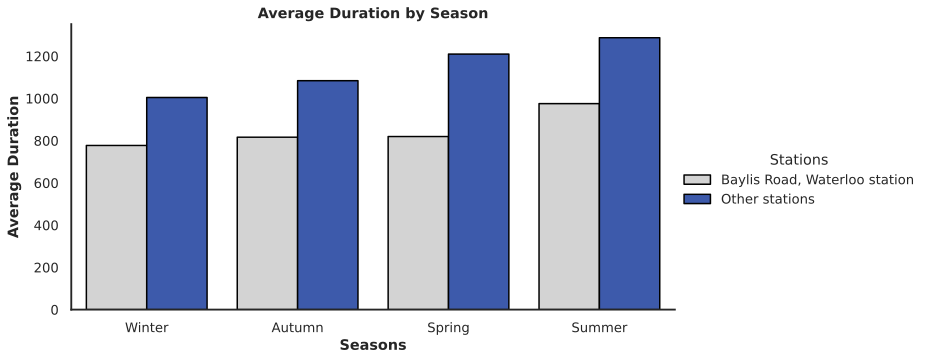

In [ ]:
# Using Catplot to illusrrate both samples mean across different seaons
sns.catplot(
    x='Seasons',y='avg(Duration)', hue='Stations', data=combined_mean_duration, kind='bar', aspect=2, palette=["#d3d3d3","#2A52BE"], edgecolor="Black"
    );
# Add labels and title
plt.xlabel("Seasons", fontweight='bold');
plt.ylabel("Average Duration",  fontweight='bold');
plt.title("Average Duration by Season",  fontweight='bold');

**To conclude:**
* while the average duration is expected to be lower in summer compared to winter, there might be some factors which could contribute to this unexpected outcome shuch as anomamlies in the data or geographical factors.
* overall, average duration for Baylis Road, Waterloo station is lower than other station which indicate that rides starting from Baylis Road, Waterloo station were shorter compared to other stations.
* To backup this statement we will be conduction a two-sample t-test.

Now lets look at average duration for both samples across different month and see how it changes.

In [ ]:
# Calculating mean for waterloo station by Month
waterloo_station_month = waterloo_station.groupby('Month').avg('Duration').orderBy('Month').toPandas()

In [ ]:
# Calculating mean for other stations by Month
other_stations_month = other_stations.groupby('Month').avg('Duration').orderBy('Month').toPandas()

In [ ]:
waterloo_station_month["Stations"]= 'Baylis Road, Waterloo_station'
other_stations_month["Stations"]= 'Other stations'

In [ ]:
combined_month = pd.concat([waterloo_station_month,other_stations_month], axis=0)

In [ ]:
Stations = combined_month.groupby('Stations')

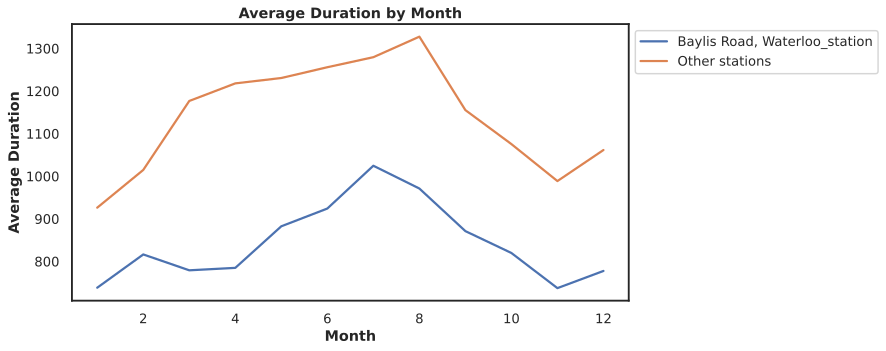

In [ ]:
# We use for loop to read both stations and their average duration across different months in 2014 to see how duration change based om months
for stations_name, duration in Stations:
    plt.plot(duration["Month"], duration["avg(Duration)"], label=stations_name)

# Add labels and title
plt.xlabel("Month", fontweight='bold');
plt.ylabel("Average Duration",fontweight='bold');
plt.title("Average Duration by Month",fontweight='bold');
# We use below code to show both stations and move it outside the plot for better readability
plt.legend(loc='upper left', bbox_to_anchor=(1, 1));

**Overall**, as we can see, while people tend to spend more times riding bikes from April to August, which make Summer a favorable season for bike riders as they spend more times riding, this figure change for Autumn and Winter as the weather is not favorable by the bike riders and they can not spend more time outside due to weather condition.

In [ ]:
# We take a sample due to computational cost
waterloo_sample = waterloo_station.sample(fraction=0.1, seed=1)

# Then we convert Spark data frame into pandas dataframe
waterloo_df= waterloo_sample.toPandas()

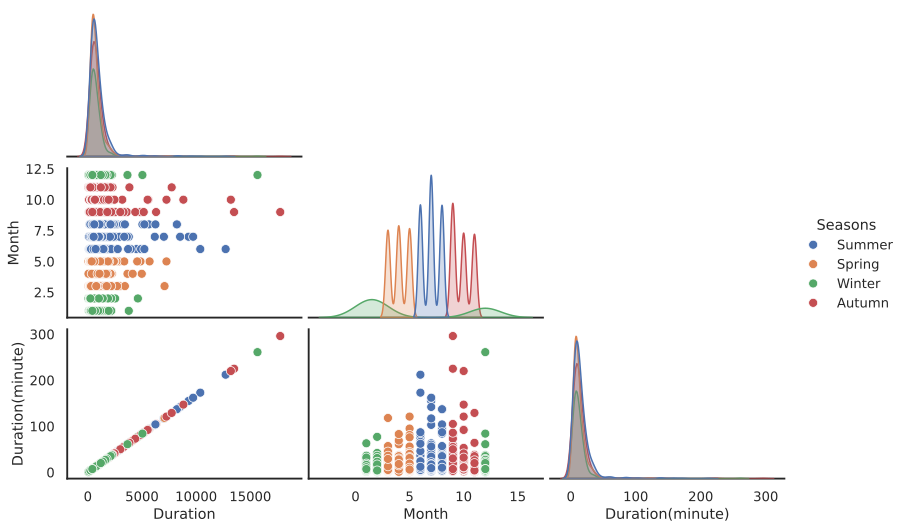

In [ ]:
sns.pairplot(waterloo_df, diag_kind='kde', corner='lower', aspect = 1.5, hue='Seasons');

* Taking clues from above plot, we can clearly see that the distribution of duration is positively skewed which indicate that we still have some outliers but not significant portion.

* We can not identify any clear pattern between Month and Duration, as we saw before duration increase between May and October, but we can see also there is large variance between the data points. There might be some interactions between the features that resulted in this variance. Further domain knowledge and more features like weather condition might explain this phenomenon.



## ✅ **Part 5:** <i>Hypothesis Test</i>

* in this section we will be doing the objective of this project which is investigating wether rides in 2014 starting from Baylis Road, Waterloo station were shorter compared to other stations.

* we will be using a two-sample t-test which is a statisticsl test which is used to compare means of two groups and find out whether there is a significant difference between the groups or not.

* we will be having two hypothesis null hypothesis and alternative hypothesis.

* Null hypothesis indicate that there is no significant difference between  Baylis Road, Waterloo station average duration and other stations average duration ----> **H_0 Mu_baylis_road = Mu_other_stations or greater than the average ride length from other stations.**

* Alternative hypothesis indicate that there is a significant difference between Baylis Road, Waterloo station average duration and other stations average duration -------> **H_1** there is a significant difference between **Mu_baylis_road** and **Mu_other_stations and ride length from Baylis Road, Waterloo station is shorter than the average ride length from other stations.**


In [ ]:
# Importing ttes from scipy library
from scipy.stats import ttest_ind

In [ ]:
waterloo_station_Duration = waterloo_station.select('Duration').toPandas().to_numpy().ravel()
other_station_Duration = other_stations.select('Duration').toPandas().to_numpy().ravel()

In [ ]:
ttest, p_value = ttest_ind(a= waterloo_station_Duration.astype(np.int64), b = other_station_Duration.astype(np.int64), equal_var=False )

In [ ]:
if p_value <= 0.05:
  print("We reject the null hypothesis as ride length from Baylis Road, Waterloo station is shorter than the average ride length from other stations.")

else:
  print("We accept the null hypothesis as there is no significant difference between Baylis Road, Waterloo station average duration and other stations average duration")

We reject the null hypothesis as ride length from Baylis Road, Waterloo station is shorter than the average ride length from other stations.


In [ ]:
waterloo_mean = waterloo_station.select(mean(col("Duration"))).toPandas()
other_station_mean = other_stations.select(mean(col("Duration"))).toPandas()

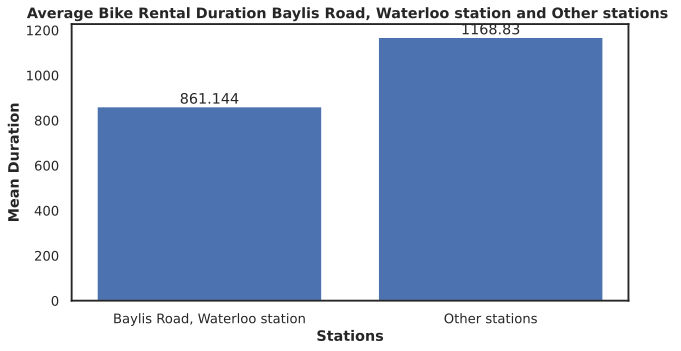

In [ ]:
duration_bar = plt.bar(["Baylis Road, Waterloo station", "Other stations"],[waterloo_mean["avg(Duration)"].item(), other_station_mean["avg(Duration)"].item()]);
plt.xlabel('Stations', fontweight='bold');
plt.ylabel('Mean Duration', fontweight='bold');
plt.title('Average Bike Rental Duration Baylis Road, Waterloo station and Other stations ', fontweight='bold');
plt.bar_label(duration_bar);

Based on above test and graph we confirm that rides in 2014 starting from Baylis Road, Waterloo station were shorter compared to other stations.